<a href="https://colab.research.google.com/github/marrs-lab/ocean_color/blob/main/oc4_algo_recreating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NASA OC4 Algorithm from NOMAD

This notebook aims to recreate the OC4 ocean color band ratio algorithm from NASA's chlorophyll ATBD (https://oceancolor.gsfc.nasa.gov/atbd/chlor_a). The most current of the OCx algorithm series which was first outlined in O'Reilly et al's *Ocean color chlorophyll algorithms for SeaWiFS*. https://doi.org/10.1029/98JC02160

Author of this notebook is Patrick Gray (patrick.c.gray@duke.edu) at the Duke University Marine Lab in the Marine Robotics and Remote Sensing Lab (http://marineuas.net/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

Pull in the NOMAD dataset

This is just the NOMAD dataset but with all the header removed except the column names

In [4]:
df = pd.read_csv('https://seabass.gsfc.nasa.gov/wiki/NOMAD/nomad_seabass_v2.a_2008200.txt', skiprows=list(range(0,88)) + [89,90])
df = df.rename(columns={'/fields=year': 'year'})

print(df.shape)
df.head()

(4459, 217)


,year,month,day,hour,minute,second,lat,lon,id,oisst,etopo2,chl,chl_a,kd405,kd411,kd443,kd455,kd465,kd489,kd510,kd520,kd530,kd550,kd555,kd560,kd565,kd570,kd590,kd619,kd625,kd665,kd670,kd683,lw405,lw411,lw443,lw455,lw465,lw489,lw510,...,bbr510,bbr514,bbr532,bbr550,bbr555,bbr589,bbr620,bbr671,bbr676,bbr870,wt,sal,poc,kpar,z_37,z_10,z_01,chlide_a,mv_chl_a,dv_chl_a,chl_c3,chl_c2,chl_c1c2,perid,but-fuco,hex-fuco,fuco,pras,viola,diadino,allo,diato,lut,zea,chl_b,beta-car,alpha-car,alpha-beta-car,flag,cruise
0,2003,4,15,15,15,0,38.4279,-76.61,1565,3.70,0.0,38.19,-999.0,-999.0,3.9455,3.1457,2.9253,-999.0,2.1736,1.8802,-999.0,1.5514,-999.0,1.2106,-999.0,1.1004,-999.0,1.0474,-999.0,1.2063,-999.0,1.7324,1.6464,-999.0,0.129962,0.204331,0.299114,-999.0,0.452029,0.541019,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
1,2003,4,15,16,50,0,38.3680,-76.50,1566,3.70,0.0,35.01,-999.0,-999.0,2.5637,2.0529,1.8386,-999.0,1.4397,1.2342,-999.0,1.0148,-999.0,0.8371,-999.0,0.7567,-999.0,0.7277,-999.0,0.9150,-999.0,1.3909,1.3261,-999.0,0.120886,0.177228,0.242677,-999.0,0.315395,0.352306,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
2,2003,4,15,17,50,0,38.3074,-76.44,1567,3.70,1.0,26.91,-999.0,-999.0,2.1533,1.7531,1.6641,-999.0,1.2676,1.0893,-999.0,0.9170,-999.0,0.7240,-999.0,0.6587,-999.0,0.6482,-999.0,0.8208,-999.0,1.2360,1.1967,-999.0,0.111049,0.151807,0.192820,-999.0,0.269218,0.326515,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
3,2003,4,17,18,15,0,38.6367,-76.32,1568,3.70,3.0,47.96,-999.0,-999.0,2.6900,2.2985,2.1297,-999.0,1.6130,1.4441,-999.0,1.2004,-999.0,0.9776,-999.0,0.8857,-999.0,0.8577,-999.0,1.0546,-999.0,1.5950,1.5343,-999.0,0.051578,0.066430,0.092185,-999.0,0.121242,0.148580,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
4,2003,7,21,18,27,0,38.3047,-76.44,1559,22.03,1.0,23.55,-999.0,-999.0,3.0950,2.3966,2.1689,-999.0,1.6452,1.3757,-999.0,1.1533,-999.0,0.9311,-999.0,0.8597,-999.0,0.8625,-999.0,1.0355,-999.0,1.2731,1.2541,-999.0,0.056001,0.068530,0.090152,-999.0,0.108838,0.132581,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0302


Assign the specific wavelengths we'll be using as well as the blue band maximum, a merged HPLC and fluorometric chla field, and then filter out any fields with missing data.

In [252]:
# blue_lw =   'lw489'
# blue_es =   'es489'
# blue_rrs =  'rrs489'

blue_rrs = 'blue_rrs'

lw_443 = 'lw443'
es_443 = 'es443'
rrs_443 = 'rrs443'

lw_510 = 'lw510'
es_510 = 'es510'
rrs_510 = 'rrs510'

lw_489 = 'lw489'
es_489 = 'es489'
rrs_489 = 'rrs489'

green_lw =  'lw555'
green_es =  'es555'
green_rrs = 'rrs555'

red_lw =    'lw670'
red_es =    'es670'
red_rrs =   'rrs670'


def chl_fcn(row):
  if row['chl_a'] != -999 :
    return (row['chl_a']) # HPLC
  else:
    return (row['chl']) # flu

df['chl_merge'] = df.apply(lambda row: chl_fcn(row), axis=1)

# whether to use only HPLC or merged chl
# Hu et al 2012 only use HPLC which is chl_a
chl = 'chl_merge' # 'chl_merge'

# make a copy to subset
df_chl = df.copy()

# create the rrs columns
df_chl[rrs_443] = df_chl[lw_443]/df_chl[es_443]
df_chl[rrs_489] = df_chl[lw_489]/df_chl[es_489]
df_chl[rrs_510] = df_chl[lw_510]/df_chl[es_510]

df_chl[green_rrs] = df_chl[green_lw]/df_chl[green_es]
df_chl[red_rrs] = df_chl[red_lw]/df_chl[red_es]

# get the max value in the blue band
# SeaWiFS is 443>490>510

# subset to delete any measurements that are missing
# filter to ensure all the SeaWiFS bands are present
df_chl = df_chl[df_chl['lw443'] != -999]
df_chl = df_chl[df_chl['lw555'] != -999]
#df_chl = df_chl[df_chl['lw670'] != -999]
df_chl = df_chl[df_chl['es443'] != -999]
df_chl = df_chl[df_chl['es555'] != -999]
#df_chl = df_chl[df_chl['es670'] != -999]
#df_chl = df_chl[df_chl['lat'] != -999]
#df_chl = df_chl[df_chl['etopo2'] != -999]
#df_chl = df_chl[df_chl['lw411'] != -999]
#df_chl = df_chl[df_chl['es411'] != -999]
df_chl = df_chl[df_chl['lw489'] != -999]
df_chl = df_chl[df_chl['es489'] != -999]
df_chl = df_chl[df_chl['lw510'] != -999]
df_chl = df_chl[df_chl['es510'] != -999]

def blue_fcn(row):
  my_list = [row[rrs_443], row[rrs_489], row[rrs_510]]
  max_value = max(my_list)
  return (max_value)

df_chl[blue_rrs] = df_chl.apply(lambda row: blue_fcn(row), axis=1)

df_chl = df_chl[df_chl[chl] != -999]

#df_chl = df_chl[df_chl[blue_rrs] > 0]
#df_chl = df_chl[df_chl[green_rrs] > 0]

#df_chl = df_chl[df_chl[chl] > 0]

#df_chl = df_chl[df_chl[chl] > .05]

# subset to only rows that were deeper than 30m
#df_chl = df_chl[df_chl['etopo2'] > 10]

# subset to lat between 60N and 60S
#df_chl = df_chl[(df_chl['lat'] < 60) & (df_chl['lat'] > -60)]

print("Number of rows remaning after filters: ", len(df_chl))

Number of rows remaning after filters:  2837


In [243]:

df_chl.loc[df_chl[chl] < 0, chl] = 0.01

In [244]:
#df = df.replace(-999, np.nan)

(-1.0, 20.0)

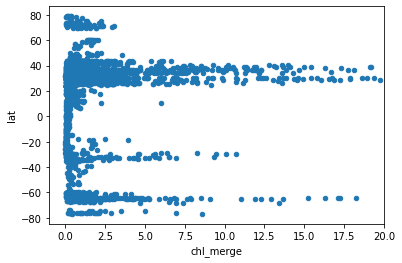

In [253]:
fig,ax = plt.subplots()

df_chl.plot(ax=ax, kind='scatter',x=chl, y='lat')
ax.set_xlim(-1,20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f70362661d0>],
      dtype=object)

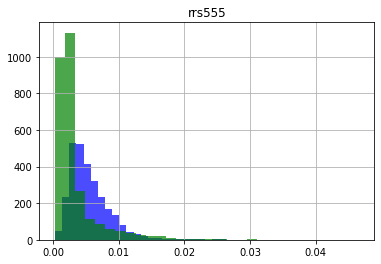

In [254]:
fig,ax = plt.subplots()
df_chl.hist(blue_rrs, bins=30,ax=ax, color='blue', alpha=0.7)
df_chl.hist(green_rrs, bins=30,ax=ax, color='green', alpha=0.7)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70405b6a90>]],
      dtype=object)

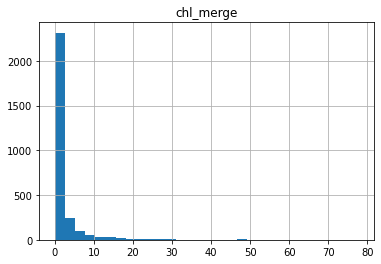

In [255]:
df_chl.hist(chl, bins=30)

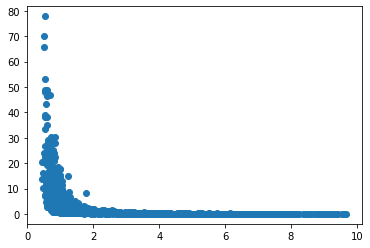

In [256]:
fig,ax = plt.subplots()

ax.scatter(df_chl[blue_rrs]/df_chl[green_rrs], df_chl[chl])

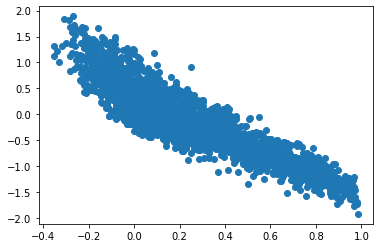

In [257]:
fig,ax = plt.subplots()

ax.scatter(x = np.log10(df_chl[blue_rrs]/df_chl[green_rrs]), y = np.log10(df_chl[chl]))

### Run the polynomial regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


RMSE =  0.2617112095738077
R2 =  0.8481203754922799


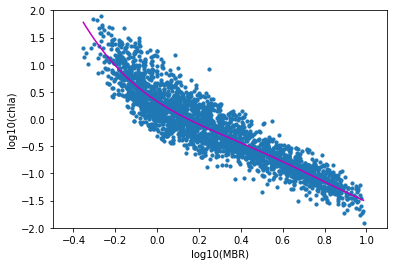

In [258]:
x = np.log10( df_chl[blue_rrs]/df_chl[green_rrs] )
y = np.log10(df_chl[chl])

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=4, include_bias=True)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print("RMSE = ", rmse)
print("R2 = ", r2)

plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)

plt.plot(x, y_poly_pred, color='m')
plt.ylabel('log10(chla)')
plt.xlabel('log10(MBR)')
plt.xlim(-0.5,1.1)
plt.ylim(-2,2)
plt.show()

In [259]:
# 0.3272	-2.9940,	2.7218,	-1.2259,	-0.5683
# 0.2412, -3.1178,  3.1792, -0.5818 , -1.5589

In [260]:
model.intercept_, model.coef_

(array([0.32467076]),
 array([[ 0.        , -2.54773131,  2.87760547, -3.84922641,  1.67840318]]))

In [198]:
polynomial_features.get_feature_names()

['1', 'x0', 'x0^2', 'x0^3', 'x0^4']

In [ ]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    thresh = [0.15, 0.20]
    a0 = 0.2424
    a1 = -2.7423
    a2 = 1.8017
    a3 = 0.0015
    a4 = -1.2280

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a